In [151]:
# Data Manipulation
import pandas as pd
import numpy as np
import requests
from io import StringIO


# Visualization (Static)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization (Interactive)
import plotly.express as px

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Import Data 

In [152]:
# 1) All variables and countries from the master data
final_df_long= pd.read_csv("https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/master_data_long.csv")
final_df_long = final_df_long.drop(columns=['Unnamed: 0'], errors='ignore')

# 2) Clusters list from Leo
clusters_list = pd.read_csv('https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/clusters_list.csv')

#### TiVA dataset

In [153]:
base_url = "https://sdmx.oecd.org/sti-public/rest/data"
query = (
    "OECD.STI.PIE,DSD_TIVA_MAINSH@DF_MAINSH,1.1/"
    "EXGR_DVA.AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+IRL+ISR+ITA+JPN+"
    "KOR+LVA+LTU+LUX+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+SWE+CHE+TUR+GBR+USA+AGO+ARG+BGD+BLR+BRA+"
    "BRN+BGR+KHM+CMR+CHN+COD+CIV+HRV+CYP+EGY+HKG+IND+IDN+JOR+KAZ+LAO+MYS+MLT+MAR+MMR+NGA+PAK+PER+"
    "PHL+ROU+RUS+STP+SAU+SEN+SGP+ZAF+TWN+THA+TUN+UKR+ARE+VNM._T.W..A"
)

# Query parameters including the CSV format
params = {
    "startPeriod": "1995",
    "endPeriod": "2022",
    "dimensionAtObservation": "AllDimensions",
    "format": "csvfilewithlabels"
}

url = f"{base_url}/{query}"

response = requests.get(url, params=params)

tiva = pd.read_csv(StringIO(response.text))

tiva = tiva[['REF_AREA', 'Reference area', 'TIME_PERIOD','OBS_VALUE']]

tiva = tiva.rename(columns={
    'REF_AREA' : 'Country Code',
    'Reference area' : 'Country Name',
    'TIME_PERIOD': 'Year',
    'OBS_VALUE': 'Value'  
})

tiva_clusters = tiva.merge(
    clusters_list,
    how='outer',
    on=['Country Code']
)

tiva_clusters = tiva_clusters[tiva_clusters['cluster_6'].isin([1, 2, 4])]
tiva_clusters

,Country Code,Country Name_x,Year,Value,Country Name_y,cluster_6
86,AUS,Australia,2009.0,87.166,Australia,4.0
87,AUS,Australia,2007.0,87.914,Australia,4.0
88,AUS,Australia,2008.0,88.076,Australia,4.0
89,AUS,Australia,2013.0,89.043,Australia,4.0
90,AUS,Australia,2010.0,89.376,Australia,4.0
...,...,...,...,...,...,...
2070,TGO,NaN,NaN,NaN,Togo,4.0
2099,TJK,NaN,NaN,NaN,Tajikistan,4.0
2100,TKM,NaN,NaN,NaN,Turkmenistan,2.0
2244,UZB,NaN,NaN,NaN,Uzbekistan,4.0


# Cluster variations across time 

### Pre-processing 

In [154]:
# I will take 5-year averages (from 1991 to 1995, and 2020 to 2024)
# Only use years from 2015 to 2021
final_df_long['Year'] = final_df_long['Year'].astype(int)
df_start_end = final_df_long[final_df_long['Year'].isin([1991, 1992, 1993, 1994, 1995, 2015, 2016, 2017, 2018, 2019])].copy()

# Pivot the data to wide format
data_pivot_var = df_start_end.pivot_table(
    index=['Country Code', 'Variable'], 
    columns='Year', 
    values='Value'
)

# Take 5-year averages
years_91_95 = [1991, 1992, 1993, 1994, 1995]
years_20_24 = [2015, 2016, 2017, 2018, 2019]

data_pivot_var['avg_1991_1995'] = data_pivot_var[years_91_95].mean(axis=1)
data_pivot_var['avg_2020_2024'] = data_pivot_var[years_20_24].mean(axis=1)

# Calculate absolute change between 5-year averages
df_change = (data_pivot_var['avg_2020_2024'] - data_pivot_var['avg_1991_1995']).reset_index()
df_change.columns = ['Country Code', 'Variable', 'Net_Change'] 

# To wide format
df_change_wide = df_change.pivot(
    index='Country Code', 
    columns='Variable', 
    values='Net_Change'
)

# Merge with clusters_list from first cluster 
df_change_clusters = df_change_wide.merge(
    clusters_list,
    how='right',
    on='Country Code'
)

#### NA check

In [155]:
df_change_clusters.shape # 136 countries

(136, 20)

In [156]:
df_change_clusters.isna().sum() # Really bad. ECI is the best.

Country Code                               0
Agriculture                               11
Economic Complexity Index                  4
GDP per capita (constant prices, PPP)      5
Government revenue                        35
High-tech exports                        136
Industry                                  13
Manufacturing                             27
NY.GDP.MINR.RT.ZS                          2
NY.GDP.NGAS.RT.ZS                          2
NY.GDP.PETR.RT.ZS                          2
NY.GDP.TOTL.RT.ZS                          2
Services                                  15
deliberative_dem                           0
egalitarian_dem                            0
electoral_dem                              0
liberal_dem                                1
participatory_dem                          0
Country Name                               0
cluster_6                                  0
dtype: int64

In [157]:
# Keep only clusters 1, 2 and 4
#df_change_clusters = df_change_clusters[df_change_clusters['cluster_6'].isin([1, 2, 4])]

# Keeping only important variables
df_change_clusters_clean = df_change_clusters[['Country Code', 'Country Name','Economic Complexity Index', 'Agriculture', 'Services','Industry', 'Manufacturing']]

df_change_clusters_clean = df_change_clusters_clean.dropna()

df_change_clusters_clean = df_change_clusters_clean .set_index(['Country Code','Country Name'])

df_change_clusters_clean

,,Economic Complexity Index,Agriculture,Services,Industry,Manufacturing
Country Code,Country Name,,,,,
ARG,Argentina,-0.3482,-0.353786,-5.540449,-5.986853,-6.289115
AUS,Australia,-0.8892,-0.750114,4.767551,-3.129904,-6.964449
AUT,Austria,-0.2710,-1.299906,4.738844,-3.539958,-1.321041
AZE,Azerbaijan,-0.8720,-22.608840,3.079893,17.257634,-11.277662
BGD,Bangladesh,-0.1796,-15.577015,6.369382,8.232347,4.731067
...,...,...,...,...,...,...
ARE,United Arab Emirates,0.3880,-0.816063,6.217557,-5.401494,1.893441
GBR,United Kingdom,-0.1026,-0.640672,1.844366,-8.055194,-6.764529
URY,Uruguay,-0.3334,-2.135691,-0.978759,-11.335264,-11.321650


## K-elbow

In [158]:
#Scale the data
scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
    scaler_filtered.fit_transform(df_change_clusters_clean),
    columns=['Economic Complexity', 'Agriculture', 'Industry','Services','Manufacturing'], 
    index=df_change_clusters_clean.index
)

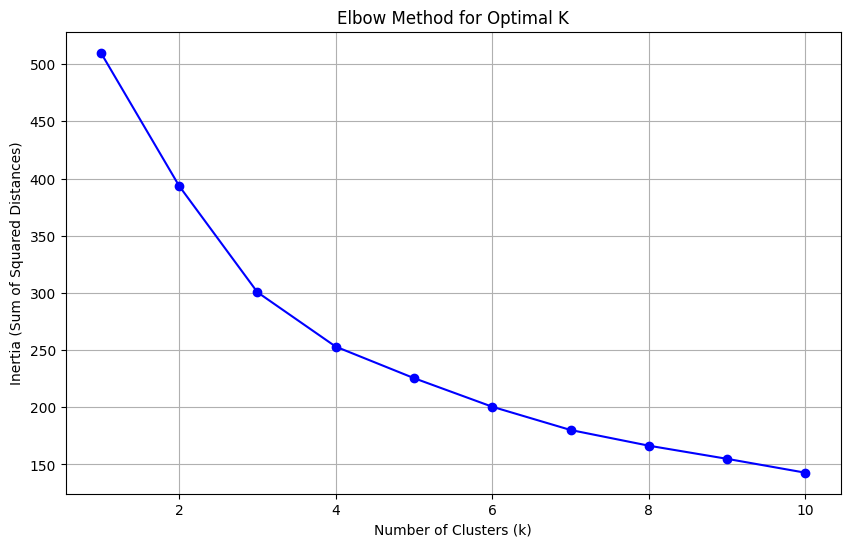

In [159]:
#Do the k-elbow plot
inertia = []
K_range = range(1, 11) 
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20) 
    kmeans.fit(countries_scaled_filtered_df)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

### 1) Cluster labels (discrete labels)

PCA Loadings (Influence of each variable on the axes):
                          PC1       PC2
Economic Complexity  0.206651  0.039511
Agriculture         -0.291954  0.699433
Industry            -0.273290 -0.684902
Services             0.603878 -0.137933
Manufacturing        0.585571  0.107131
cluster_3            0.299682  0.098178


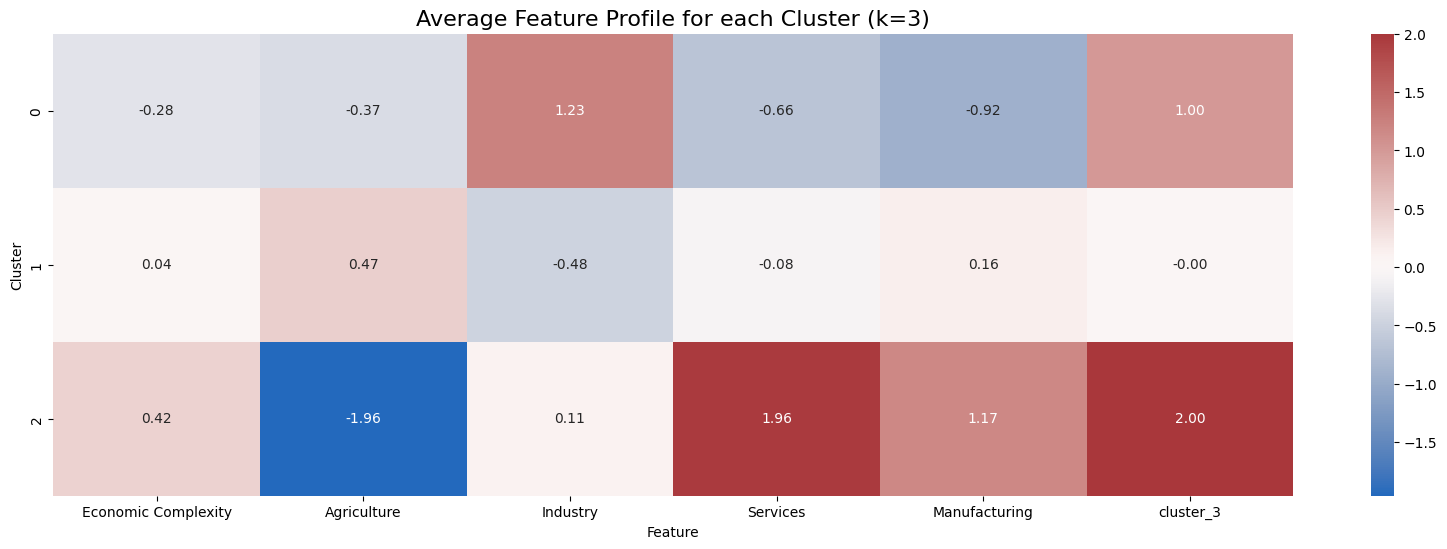

In [161]:
#Fit the k=6 model
k_country_3_filtered_var = KMeans(n_clusters=3, random_state=0, n_init=100)
k_country_3_filtered_var.fit(countries_scaled_filtered_df) 

#PCA and Visualization (as before)
data_for_pca_var = countries_scaled_filtered_df
countries_scaled_filtered_df['cluster_3'] = k_country_3_filtered_var.labels_
pca = PCA(n_components=2)
pca_components_var = pca.fit_transform(data_for_pca_var)
pca_df_var = pd.DataFrame(
    data=pca_components_var, 
    columns=['PC1', 'PC2'], 
    index=data_for_pca_var.index
)

# Add the labels from your main df
pca_df_var['cluster_3'] = countries_scaled_filtered_df['cluster_3']

# Extract Loadings 
loadings_var = pd.DataFrame(
    pca.components_.T,  
    columns=['PC1', 'PC2'],
    index=data_for_pca_var.columns  
)
print("PCA Loadings (Influence of each variable on the axes):")
print(loadings_var)

centroids_k3_var = k_country_3_filtered_var.cluster_centers_
centroid_df_k3_var = pd.DataFrame(
    centroids_k3_var, 
    columns=data_for_pca_var.columns 
)
pca_df_var['Country Code'] = pca_df_var.index 

plt.figure(figsize=(20, 6)) 
sns.heatmap(
    centroid_df_k3_var, 
    annot=True, 
    cmap='vlag', 
    fmt='.2f'
)
plt.title('Average Feature Profile for each Cluster (k=3)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

### ECI list (continuous labels)

In [171]:
df_change_eci = df_change_clusters[['Country Code', 'Country Name', 'Economic Complexity Index', 'cluster_6']]

df_change_eci

# Create a categorical variable with 3 equally sized groups
df_change_eci['label'] = pd.qcut(
    df_change_eci['Economic Complexity Index'], 
    q=3,  # split into 3 quantiles
    labels=['Not Successful', 'Mid Successful', 'Successful']
)

C:\Users\iorueta\AppData\Local\Temp\ipykernel_54068\936551922.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



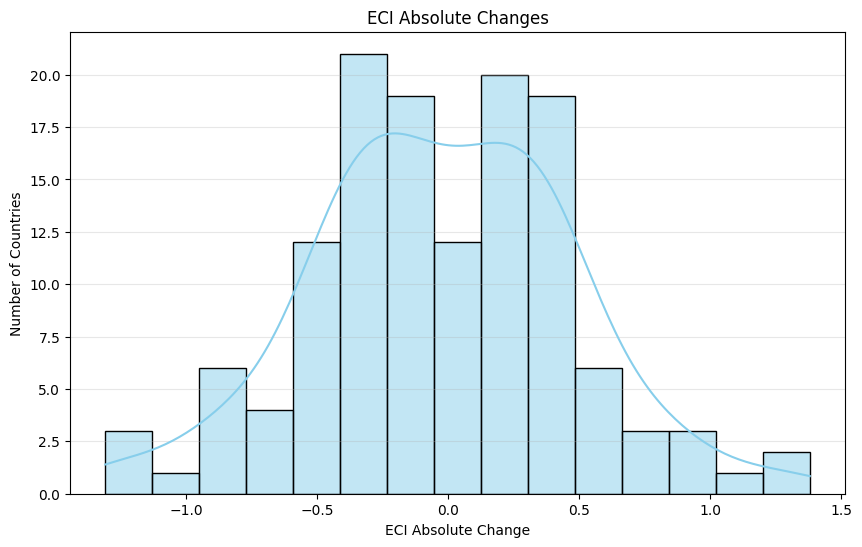

In [164]:
# --- 1. Histogram of ECI changes ---
plt.figure(figsize=(10,6))
sns.histplot(df_change_eci['Economic Complexity Index'], bins=15, kde=True, color='skyblue')
plt.title('ECI Absolute Changes')
plt.xlabel('ECI Absolute Change')
plt.ylabel('Number of Countries')
plt.grid(axis='y', alpha=0.3)
plt.show()

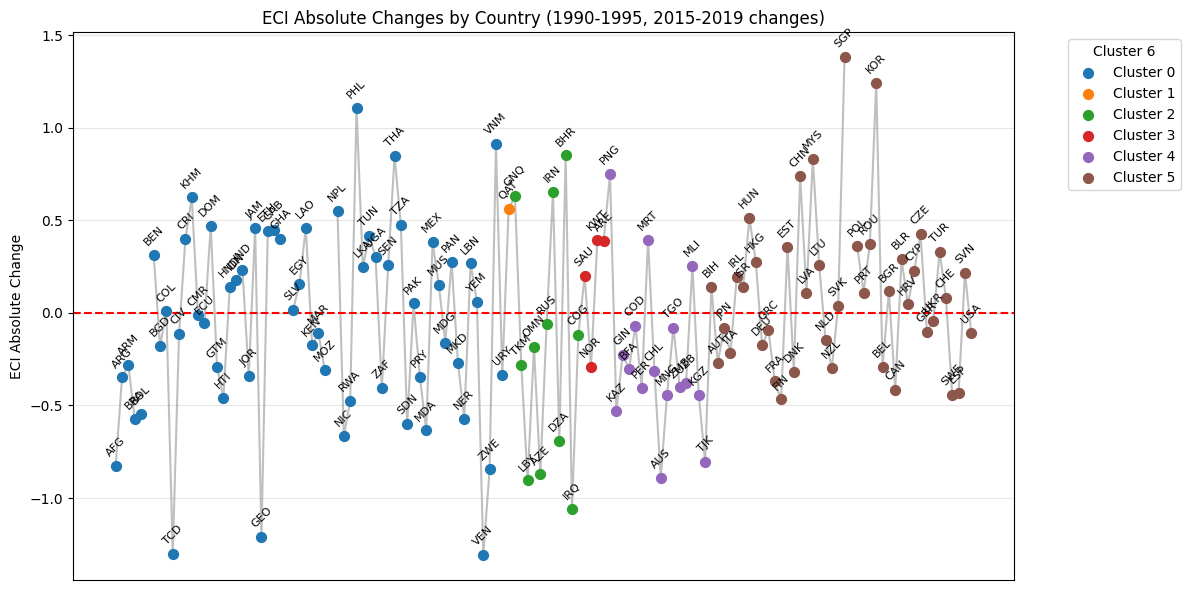

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by cluster_6
df_sorted = df_change_eci.sort_values('cluster_6').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['cluster_6'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and annotate
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['cluster_6'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                     color=cluster_colors[cluster], s=50, label=f'Cluster {cluster}', zorder=3)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)

# Remove x-axis labels
plt.xticks([])

plt.title('ECI Absolute Changes by Country (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('ECI Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Cluster 6', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

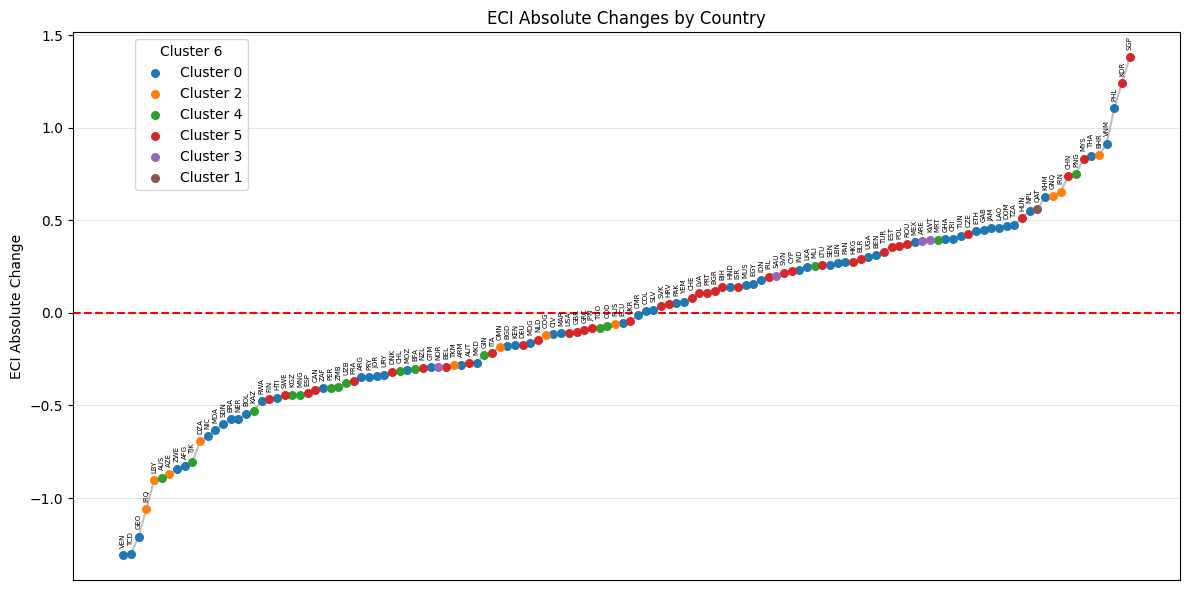

In [ ]:
# Sort by ECI change
df_sorted = df_change_eci.sort_values('Economic Complexity Index').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['cluster_6'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and keep references for legend
scatter_handles = []
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['cluster_6'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                     color=cluster_colors[cluster], s=30, label=f'Cluster {cluster}', zorder=3)
    scatter_handles.append(sc)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=5, rotation=90)


# Remove x-axis labels
plt.xticks([])
# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)
plt.title('ECI Absolute Changes by Country (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('ECI Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Cluster 6', bbox_to_anchor=(.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

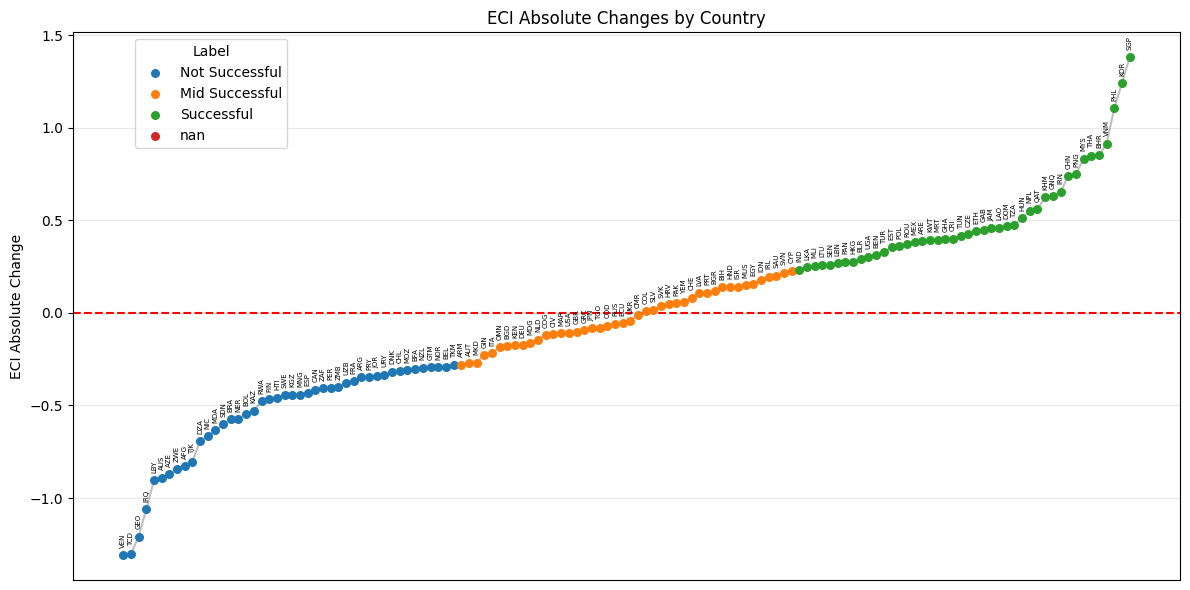

In [ ]:
# Sort by ECI change
df_sorted = df_change_eci.sort_values('Economic Complexity Index').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['label'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and keep references for legend
scatter_handles = []
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['label'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                     color=cluster_colors[cluster], s=30, label=f'{cluster}', zorder=3)
    scatter_handles.append(sc)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=5, rotation=90)


# Remove x-axis labels
plt.xticks([])
# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)
plt.title('ECI Absolute Changes by Country (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('ECI Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Label', bbox_to_anchor=(.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Export matrix sophistication

In [184]:
products = pd.read_csv(r"C:\Users\iorueta\PC IGNACIO\0.LSE\MPA DSPP\3. Autumm Term 2025\Capstone Moody's\Capstone\rawdata\hs92_country_product_year_2.csv")

# Inspect
products.head()

,country_id,country_iso3_code,product_id,product_hs92_code,year,export_value,import_value,global_market_share,distance,cog,pci
0,4,AFG,100,1,1995,14517,0,0.000001,0.943,0.001,-0.565
1,4,AFG,100,1,1996,17207,0,0.000002,0.951,0.001,-0.631
2,4,AFG,100,1,1997,22781,0,0.000003,0.938,0.001,-0.519
3,4,AFG,100,1,2000,0,7786,0.000000,0.931,0.001,-0.605
4,4,AFG,100,1,2001,0,15592,0.000000,0.930,0.001,-0.825


In [186]:
YEAR = 2015   # choose a year
products_2015 = products[products['year'] == YEAR].copy()

In [189]:
# Total exports by country
country_totals = products_2015.groupby('country_iso3_code')['export_value'].sum()

# Total exports by product
product_totals = products_2015.groupby('product_id')['export_value'].sum()

# World total exports
world_total = products_2015['export_value'].sum()

# Merge totals
products_2015 = products_2015.merge(country_totals, on='country_iso3_code', suffixes=('', '_country'))
products_2015 = products_2015.merge(product_totals, on='product_id', suffixes=('', '_product'))

# RCA
products_2015['RCA'] = (
    (products_2015['export_value'] / products_2015['export_value_country']) /
    (products_2015['export_value_product'] / world_total)
)


products_2015['M'] = (products_2015['RCA'] >= 1).astype(int)

M = products_2015.pivot_table(
    index='country_iso3_code',
    columns='product_id',
    values='M',
    fill_value=0
)

In [190]:
M

product_id,100,101,102,103,104,105,106,107,108,109,...,187,188,189,190,191,192,193,194,195,196
country_iso3_code,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AIA,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
ALB,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
YEM,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZAF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
